In [1]:
%pylab inline
from constant import * 

Populating the interactive namespace from numpy and matplotlib


In [2]:
Vgrid = np.load("ValueGamma4HugeCost25.npy")
gamma

4

In [3]:
num = 10000
'''
    x = [w,n,m,s,e,o]
    x = [5,0,0,0,0,0]
'''

from jax import random

def simulation(key):
    initE = random.choice(a = nE, p=E_distribution, key = key)
    initS = random.choice(a = nS, p=S_distribution, key = key)
    x = [5, 0, 0, initS, initE, 0]
    path = []
    move = []
    for t in range(T_min, T_max):
        _, key = random.split(key)
        if t == T_max-1:
            _,a = V(t,Vgrid[:,:,:,:,:,:,t],x)
        else:
            _,a = V(t,Vgrid[:,:,:,:,:,:,t+1],x)
        xp = transition(t,a.reshape((1,-1)),x)
        p = xp[:,-1]
        x_next = xp[:,:-1]
        path.append(x)
        move.append(a)
        x = x_next[random.choice(a = nS*nE, p=p, key = key)]
    path.append(x)
    return jnp.array(path), jnp.array(move)

In [4]:
%%time
# simulation part 
keys = vmap(random.PRNGKey)(jnp.arange(num))
Paths, Moves = vmap(simulation)(keys)

CPU times: user 4h 31min 8s, sys: 25min 11s, total: 4h 56min 20s
Wall time: 13min 39s


In [5]:
# x = [w,n,m,s,e,o]
# x = [0,1,2,3,4,5]
ws = Paths[:,:,0].T
ns = Paths[:,:,1].T
ms = Paths[:,:,2].T
ss = Paths[:,:,3].T
es = Paths[:,:,4].T
os = Paths[:,:,5].T
cs = Moves[:,:,0].T
bs = Moves[:,:,1].T
ks = Moves[:,:,2].T
hs = Moves[:,:,3].T
actions = Moves[:,:,4].T

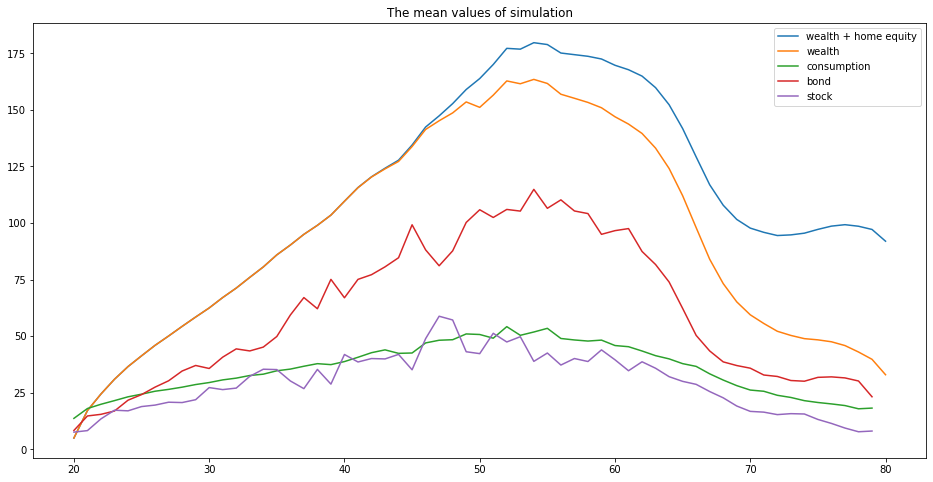

In [6]:
plt.figure(figsize = [16,8])
plt.title("The mean values of simulation")
plt.plot(range(20, T_max + 21),jnp.mean(ws + H*pt*os - ms,axis = 1), label = "wealth + home equity")
plt.plot(range(20, T_max + 21),jnp.mean(ws,axis = 1), label = "wealth")
plt.plot(range(20, T_max + 20),jnp.mean(cs,axis = 1), label = "consumption")
plt.plot(range(20, T_max + 20),jnp.mean(bs,axis = 1), label = "bond")
plt.plot(range(20, T_max + 20),jnp.mean(ks,axis = 1), label = "stock")
plt.legend()

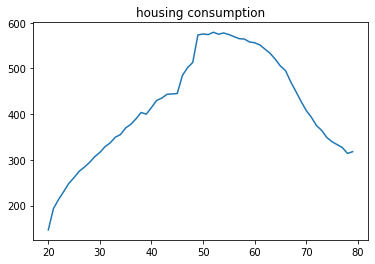

In [7]:
plt.title("housing consumption")
plt.plot(range(20, T_max + 20),(hs).mean(axis = 1), label = "housing")

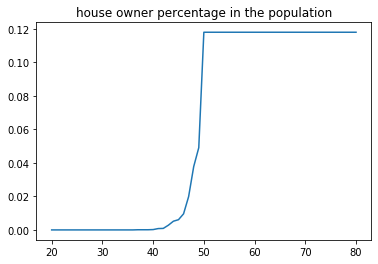

In [8]:
plt.title("house owner percentage in the population")
plt.plot(range(20, T_max + 21),(os).mean(axis = 1), label = "owning")

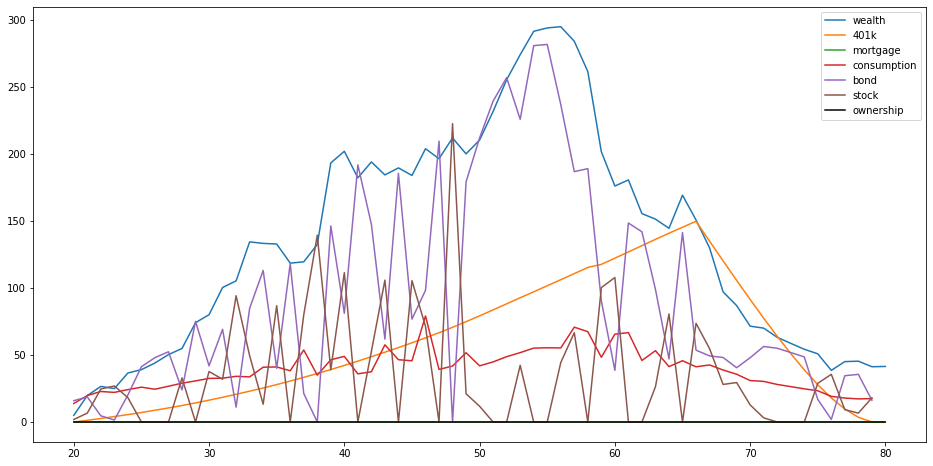

In [9]:
# agent number, x = [w,n,m,s,e,o]
agentNum = 6
plt.figure(figsize = [16,8])
plt.plot(range(20, T_max + 21),ws[:,agentNum], label = "wealth")
plt.plot(range(20, T_max + 21),ns[:,agentNum], label = "401k")
plt.plot(range(20, T_max + 21),ms[:,agentNum], label = "mortgage")
plt.plot(range(20, T_max + 20),cs[:,agentNum], label = "consumption")
plt.plot(range(20, T_max + 20),bs[:,agentNum], label = "bond")
plt.plot(range(20, T_max + 20),ks[:,agentNum], label = "stock")
plt.plot(range(20, T_max + 21),os[:,agentNum]*100, label = "ownership", color = "k")
plt.legend()

In [10]:
# agent selling time collection
agentTime = []
for t in range(30):
    if ((os[t,:] == 0) & (os[t+1,:] == 1)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 0) & (os[t+1,:] == 1))[0]:
            agentTime.append([t, agentNum])
agentTime = jnp.array(agentTime)

In [11]:
# agent selling time collection
agentHold = []
for t in range(30):
    if ((os[t,:] == 0) & (os[t+1,:] == 0)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 0) & (os[t+1,:] == 0))[0]:
            agentHold.append([t, agentNum])
agentHold = jnp.array(agentHold)

(array([  1.,   0.,   0.,   0.,   1.,   0.,   6.,   1.,   0.,  19.,  24.,
          0.,   9.,  35.,   0., 103., 179.,   0., 113., 689.]),
 array([16.  , 16.65, 17.3 , 17.95, 18.6 , 19.25, 19.9 , 20.55, 21.2 ,
        21.85, 22.5 , 23.15, 23.8 , 24.45, 25.1 , 25.75, 26.4 , 27.05,
        27.7 , 28.35, 29.  ]),
 <a list of 20 Patch objects>)

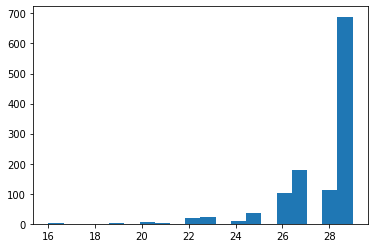

In [12]:
plt.hist(agentTime[:,0], bins = 20)

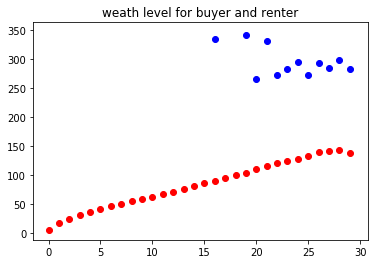

In [14]:
plt.title("weath level for buyer and renter")
for age in range(30):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    plt.scatter(age, ws[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    plt.scatter(age, ws[renter[:,0], renter[:,1]].mean(),color =  "r")

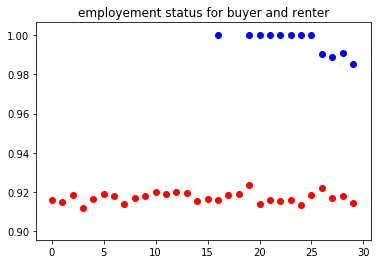

In [15]:
plt.title("employement status for buyer and renter")
for age in range(31):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    plt.scatter(age, es[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    plt.scatter(age, es[renter[:,0], renter[:,1]].mean(),color =  "r")

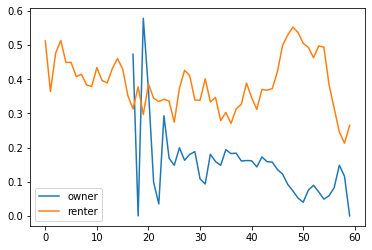

In [20]:
# At every age
plt.plot((os[:T_max,:]*ks/(ks+bs)).sum(axis = 1)/os[:T_max,:].sum(axis = 1), label = "owner")
plt.plot(((1-os[:T_max,:])*ks/(ks+bs)).sum(axis = 1)/(1-os)[:T_max,:].sum(axis = 1), label = "renter")
plt.legend()

In [18]:
# agent selling time collection
agentTime = []
for t in range(30):
    if ((os[t,:] == 1) & (os[t+1,:] == 0)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 1) & (os[t+1,:] == 0))[0]:
            agentTime.append([t, agentNum])
agentTime = jnp.array(agentTime)

In [19]:
agentTime = agentTime[(agentTime[:,0] > 10) & (agentTime[:,0] < 15)]

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 1.

In [ ]:
# agent at the same time time collection
agentTimeKeep = []
for t in set(jnp.array(agentTime[:,0], dtype = int8)):
    if ((os[t,:] == 1) & (os[t+1,:] == 1)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 1) & (os[t+1,:] == 1))[0]:
            agentTimeKeep.append([t, agentNum])
agentTimeKeep = jnp.array(agentTimeKeep)

In [ ]:
def percentChange(agentTime):
    wealthBeforeSell = ws[agentTime[:,0] - 1, agentTime[:,1]] 
    wealthAtSell = ws[agentTime[:,0], agentTime[:,1]]
    return (wealthAtSell - wealthBeforeSell)/wealthBeforeSell

In [ ]:
percentChange(agentTime).mean()

In [ ]:
percentChange(agentTimeKeep).mean()

In [ ]:
es[agentTime[:,0], agentTime[:,1]].mean()

In [ ]:
es[agentTimeKeep[:,0], agentTimeKeep[:,1]].mean()